In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
alessiocorrado99_animals10_path = kagglehub.dataset_download('alessiocorrado99/animals10')

print('Data source import complete.')


Data source import complete.


# Animal Classification : VGG16

In [3]:
!pip install torchinfo
import torch
import torchvision
from torch import nn , optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchinfo import summary
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# setting up torch
device  = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.device(device)

device(type='cuda')

In [5]:
# transforms
img_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=1),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [6]:
# create dataset using ImageFolder

dataset = ImageFolder(root='/kaggle/input/animals10/raw-img', transform=img_transforms)

# creating train dataset from dataset
train_size = int(0.8 * len(dataset))
test_val_size = len(dataset) - train_size
train_dataset, test_val_dataset = random_split(dataset, [train_size, test_val_size])

# create test and validation set frm test_val_dataset
test_size = int(0.5 * len(test_val_dataset))
val_size = len(test_val_dataset) - test_size
test_dataset, val_dataset = random_split(test_val_dataset, [test_size, val_size])

len(train_dataset), len(test_dataset), len(val_dataset)

(20943, 2618, 2618)

In [7]:
# create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

len(train_loader), len(test_loader), len(val_loader)

(655, 82, 82)

In [8]:
# create visualize fuction
def visualize(dataloader):
  images, labels = next(iter(dataloader))
  grid = make_grid(images, nrow=8)
  plt.figure(figsize=(15,15))
  plt.imshow(np.transpose(grid, (1,2,0)))
  plt.show()


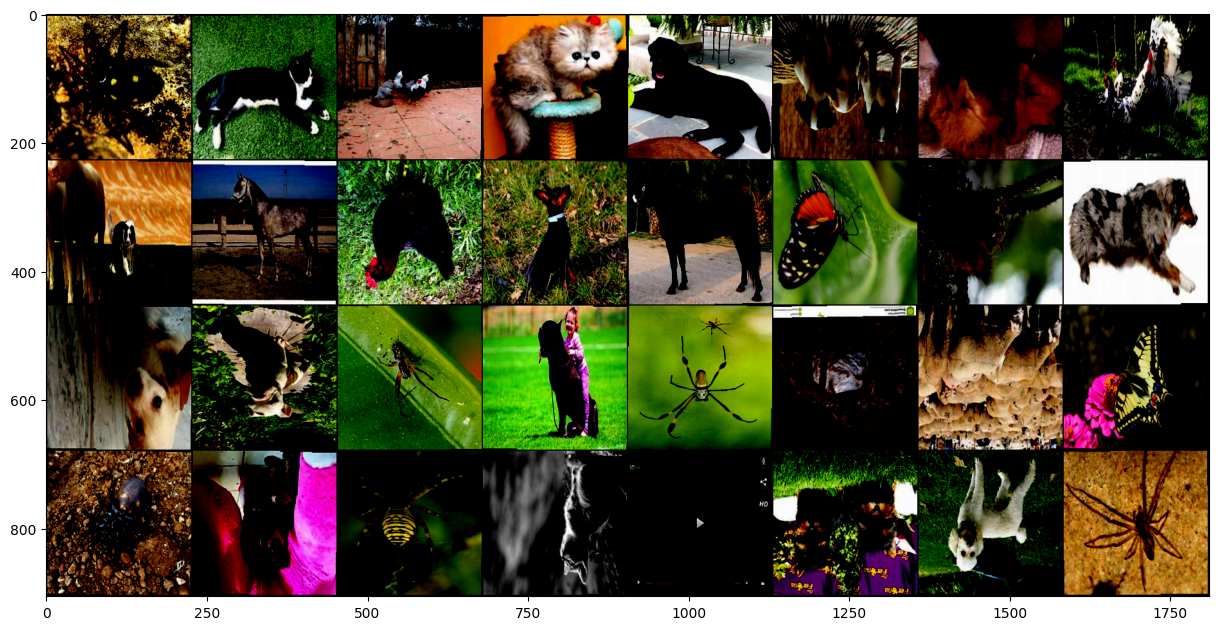

In [9]:
# visualize train dataset
visualize(train_loader)

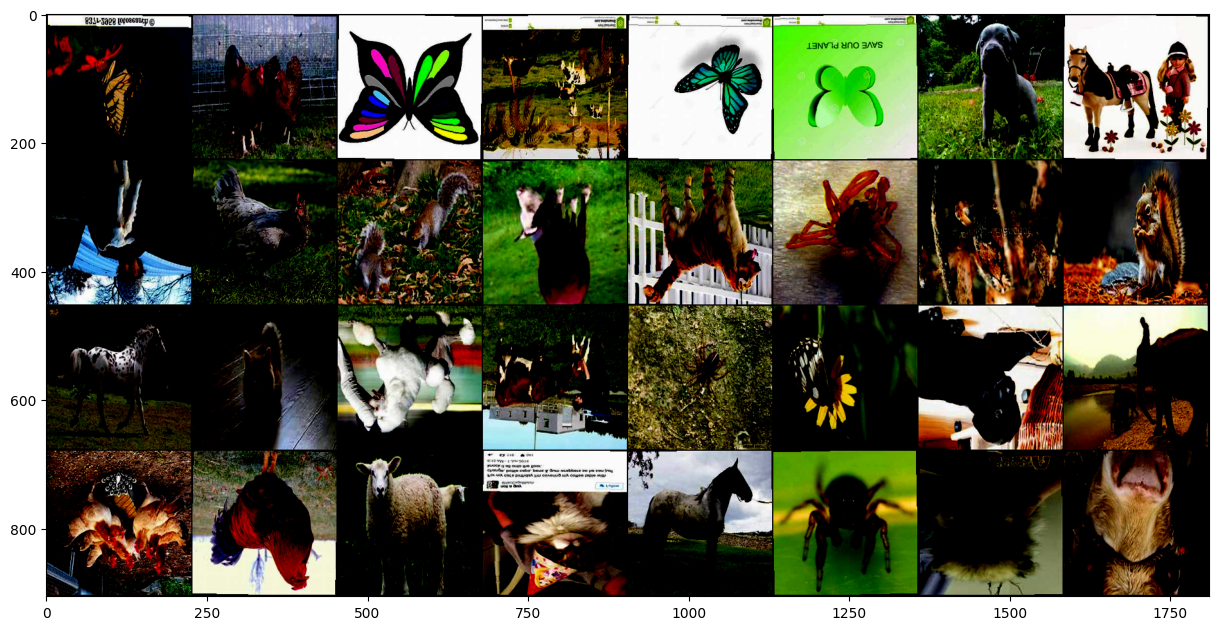

In [10]:
# visualize validation set
visualize(val_loader)

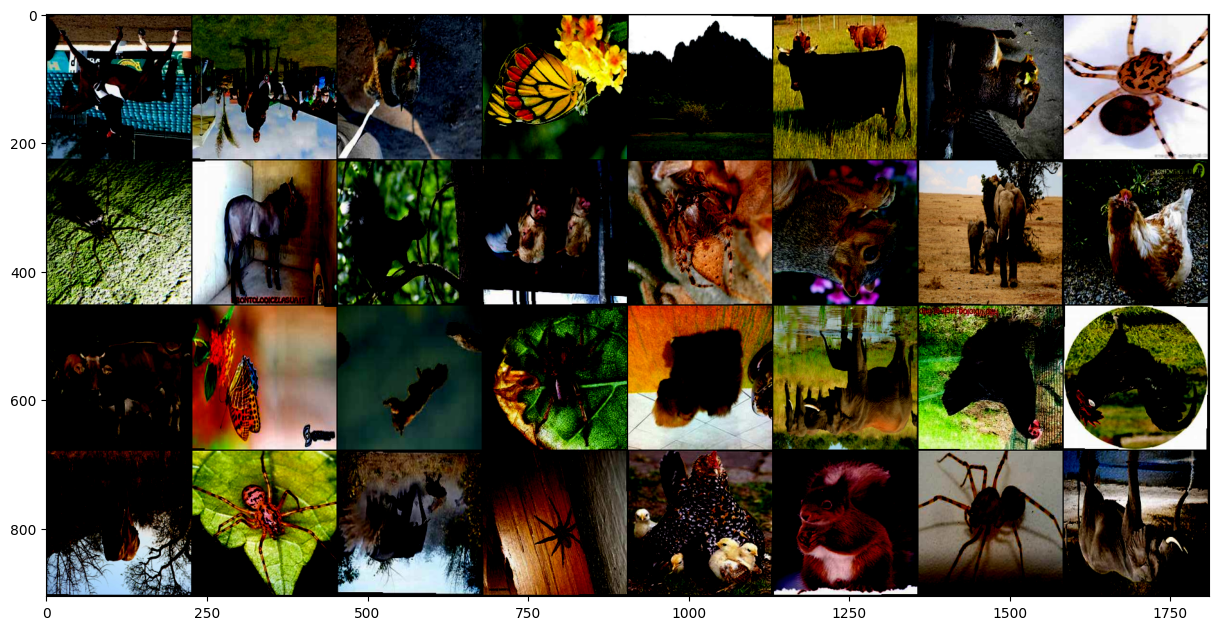

In [11]:
# visualize test set
visualize(test_loader)

In [12]:
# create vgg16 model
class VGG16(nn.Module):
  def __init__(self):
    super(VGG16,self).__init__()
    self.model = nn.Sequential(

        # first block
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        # second block
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        # third block
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        # fourth block
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        #fifth block
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        # fully connected layers
        nn.Flatten(),

        nn.Linear(in_features=512*7*7, out_features=4096),
        nn.ReLU(),
        nn.Dropout(),

        nn.Linear(in_features=4096, out_features=2048),
        nn.ReLU(),
        nn.Dropout(),

        nn.Linear(in_features=2048, out_features=80)

    )

  def forward(self, x):
    return self.model(x)


In [13]:
# create model instance
model = VGG16().to(device)

In [14]:
summary(model, input_size=(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG16                                    [1, 80]                   --
├─Sequential: 1-1                        [1, 80]                   --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─BatchNorm2d: 2-2                  [1, 64, 224, 224]         128
│    └─ReLU: 2-3                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-4                       [1, 64, 224, 224]         36,928
│    └─BatchNorm2d: 2-5                  [1, 64, 224, 224]         128
│    └─ReLU: 2-6                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-7                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        73,856
│    └─BatchNorm2d: 2-9                  [1, 128, 112, 112]        256
│    └─ReLU: 2-10                        [1, 128, 112, 112]        --
│    └─Conv2d: 2-11                      [1, 128, 112, 112]        147,

## Train Model

In [15]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()

In [17]:
# train model
epochs = 25

training_loss = []
validation_loss = []

for epoch in range(epochs):

    # Training phase
    model.train()
    epoch_train_loss = 0.0
    for images, labels in train_loader:
        # Move data to the appropriate device
        images = images.to(device)
        labels = labels.to(device)

        # Clear gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        train_loss = loss_fn(outputs, labels)

        # Backward pass
        train_loss.backward()
        optimizer.step()

        epoch_train_loss += train_loss.item() * images.size(0)  # Accumulate loss

    # Average training loss for the epoch
    epoch_train_loss /= len(train_loader.dataset)
    training_loss.append(epoch_train_loss)

    # Validation phase
    model.eval()
    epoch_val_loss = 0.0
    with torch.inference_mode():
        for val_images, val_labels in val_loader:
            # Move validation data to the appropriate device
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            val_outputs = model(val_images)
            val_loss = loss_fn(val_outputs, val_labels)
            epoch_val_loss += val_loss.item() * val_images.size(0)  # Accumulate loss

    # Average validation loss for the epoch
    epoch_val_loss /= len(val_loader.dataset)
    validation_loss.append(epoch_val_loss)

    # Print loss for the epoch
    print(f"Epoch: {epoch+1}/{epochs}, Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")


Epoch: 1/25, Training Loss: 1.8230, Validation Loss: 1.5616
Epoch: 2/25, Training Loss: 1.5105, Validation Loss: 1.4494
Epoch: 3/25, Training Loss: 1.3041, Validation Loss: 1.1512
Epoch: 4/25, Training Loss: 1.1754, Validation Loss: 1.1189
Epoch: 5/25, Training Loss: 1.0676, Validation Loss: 0.9512
Epoch: 6/25, Training Loss: 0.9870, Validation Loss: 0.9276
Epoch: 7/25, Training Loss: 0.9171, Validation Loss: 0.8926
Epoch: 8/25, Training Loss: 0.8713, Validation Loss: 0.7663
Epoch: 9/25, Training Loss: 0.8021, Validation Loss: 0.8145
Epoch: 10/25, Training Loss: 0.7565, Validation Loss: 0.8070
Epoch: 11/25, Training Loss: 0.7045, Validation Loss: 0.8713
Epoch: 12/25, Training Loss: 0.6623, Validation Loss: 0.8041
Epoch: 13/25, Training Loss: 0.6299, Validation Loss: 0.6470
Epoch: 14/25, Training Loss: 0.5954, Validation Loss: 0.8239
Epoch: 15/25, Training Loss: 0.5717, Validation Loss: 0.5926
Epoch: 16/25, Training Loss: 0.5352, Validation Loss: 0.6254
Epoch: 17/25, Training Loss: 0.51

# Visualize Losses

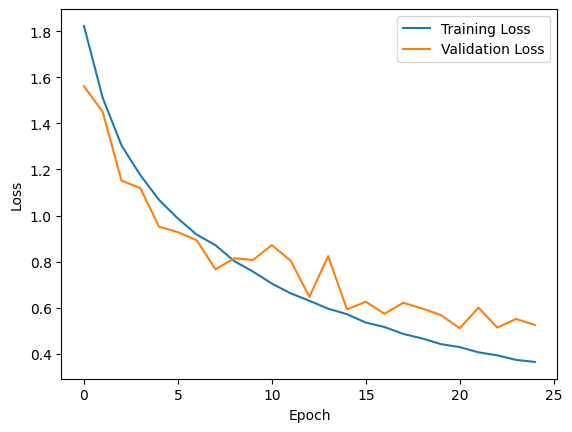

In [18]:
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Test Model

In [19]:
# Test model on test set
predicted_labels = []
actual_labels = []

model.eval()  # Set the model to evaluation mode
with torch.inference_mode():  # Ensure no gradients are computed
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        actual_labels.extend(labels.cpu().numpy())

## Evaluate Model

Model Accuracy: 84.03%
Model Precision: 85.69%
Model Recall: 84.03%
Model F1 Score: 84.24%
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       489
           1       0.86      0.69      0.77       254
           2       0.97      0.71      0.82       133
           3       0.85      0.93      0.89       181
           4       0.92      0.87      0.89       297
           5       0.91      0.78      0.84       160
           6       0.55      0.90      0.69       191
           7       0.80      0.64      0.71       158
           8       0.95      0.92      0.94       539
           9       0.79      0.86      0.82       216

    accuracy                           0.84      2618
   macro avg       0.84      0.82      0.82      2618
weighted avg       0.86      0.84      0.84      2618



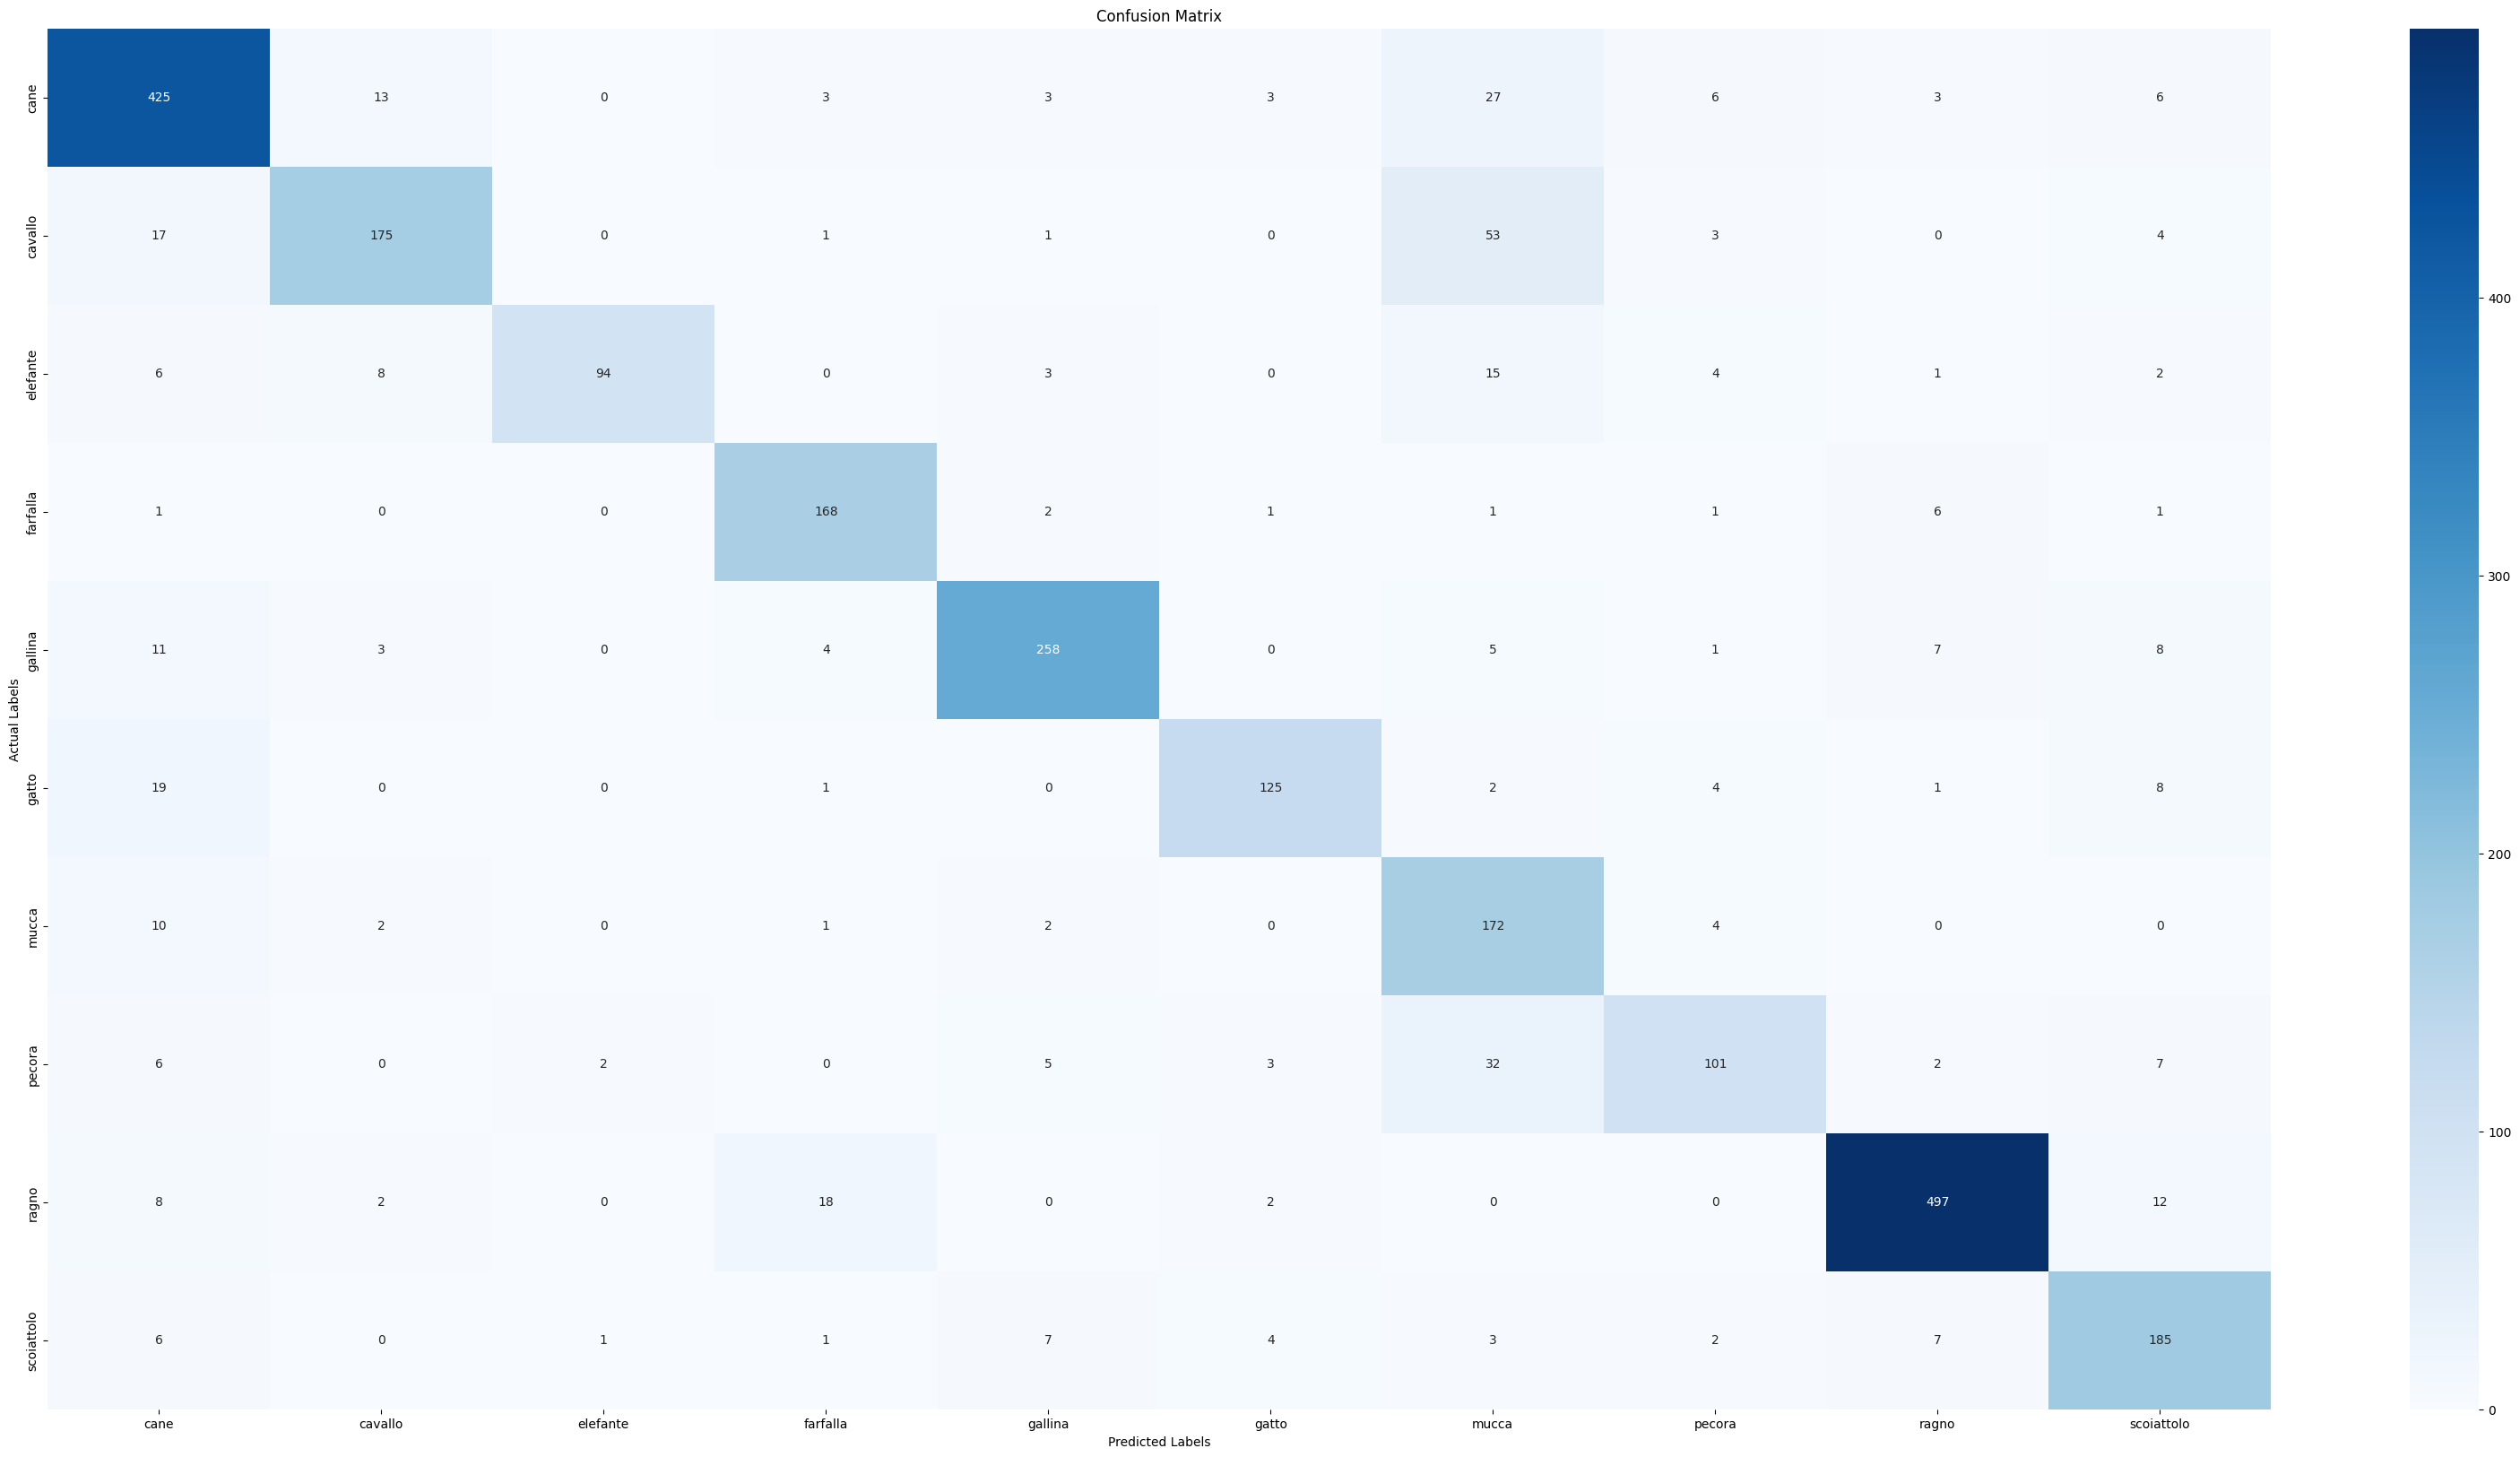

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate evaluation metrics
accuracy = accuracy_score(actual_labels, predicted_labels)
precision = precision_score(actual_labels, predicted_labels, average='weighted', zero_division=0)
recall = recall_score(actual_labels, predicted_labels, average='weighted', zero_division=0)
f1 = f1_score(actual_labels, predicted_labels, average='weighted', zero_division=0)

# Print metrics
print(f"Model Accuracy: {accuracy * 100:.2f}%")
print(f"Model Precision: {precision * 100:.2f}%")
print(f"Model Recall: {recall * 100:.2f}%")
print(f"Model F1 Score: {f1 * 100:.2f}%")

# Print classification report
print(classification_report(actual_labels, predicted_labels, zero_division=0))

# Generate and visualize confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)
class_names = dataset.classes

plt.figure(figsize=(40, 20))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()


## Save Model

In [21]:
# save model
torch.save(model.state_dict(), 'model_ram.pt')